Shannon Moran <br>
Phys 514 <br>
HW 3<br>
Due: Sept 28

### Time check
* 1/2) 1:40
* 3) 3:00
* 4) 1:00
* Final checking, updates, clean-up) 2:30

Questions to ask:
* Things are exploding-- is it an option to re-write rebox so that it loops multiple times over the box to correct for explosions?

## Import required packages

In [1]:
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import animation
import time

## Lennard Jones code supplied

In [2]:
def initialize_positions_and_velocities(rx,ry,vx,vy, Nx, Ny,L):
    dx=L/Nx;
    dy=L/Ny;
    np.random.seed(0)
    for i in range(Nx):
        for j in range(Ny):
            rx[i*Ny+j]=dx*(i+0.5)
            ry[i*Ny+j]=dy*(j+0.5)

            u=np.random.random() #This is box muller
            v=np.random.random()
            # Solves for velocities drawn from probability distribution (1.13)
            vx[i*Ny+j]=np.sqrt(-2*np.log(u))*np.cos(2.*np.pi*v)
            vy[i*Ny+j]=np.sqrt(-2*np.log(u))*np.sin(2.*np.pi*v)
    #subtract net velocity to avoid global drift
    vxav=sum(vx)/vx.size
    vyav=sum(vy)/vx.size
    vx-=vxav
    vy-=vyav

def potential(rsq):
    rsqinv=1./rsq
    r6inv=rsqinv*rsqinv*rsqinv
    return -4*r6inv*(1-r6inv)

def compute_kinetic_energy(vx,vy):
    return 0.5*sum(vx*vx+vy*vy)

def compute_potential_energy(rx,ry,rcut,L):
    rcutsq=rcut*rcut
    rcutv=potential(rcutsq) #shift the potential to avoid jump at rc
    Epot=0. 
    for i in range(rx.size):
        for j in range(i):
            dx=rx[i]-rx[j]
            dy=ry[i]-ry[j]
            #minimum image convention
            if(dx > L/2.): dx=dx-L
            if(dx <-L/2.): dx=dx+L
            if(dy > L/2.): dy=dy-L
            if(dy <-L/2.): dy=dy+L
            #print dx,dy
            #compute the distance
            rsq=dx*dx+dy*dy
            if(rsq < rcutsq):
                Epot+=potential(rsq)-rcutv
            return Epot 
        
def compute_forces(rx,ry,dV_drx, dV_dry, N, L, rcut):
    rcutsq=rcut*rcut
    for i in range(N):
        for j in range(i):
            dx=rx[i]-rx[j] ; 
            dy=ry[i]-ry[j] ; 
            #minimum image convention
            if(dx > L/2.): dx=dx-L
            if(dx <-L/2.): dx=dx+L
            if(dy > L/2.): dy=dy-L
            if(dy <-L/2.): dy=dy+L
            #compute the distance
            rsq=dx*dx+dy*dy
            #check if we are < the cutoff radius
            if(rsq < rcutsq):
                #here is the call of the force calculation
                dV_dr=force(rsq)

                #here the force is being added to the particle. Note the additional dx
                dV_drx[i]+=dx*dV_dr
                dV_drx[j]-=dx*dV_dr
                dV_dry[i]+=dy*dV_dr
                dV_dry[j]-=dy*dV_dr
            
def euler(rx,ry,vx,vy,dV_drx,dV_dry,dt):
    #update the positions
    rx+=dt*vx
    ry+=dt*vy

    #update the velocities
    vx-=dt*dV_drx
    vy-=dt*dV_dry

#put back into box:
def rebox_old(rx,ry,L):
    for i in range(rx.size):
        if rx[i] > L:
            rx[i]=rx[i]-L
        if rx[i] < 0:
            rx[i]=rx[i]+L
        if ry[i] > L:
            ry[i]=ry[i]-L
        if ry[i] < 0:
            ry[i]=ry[i]+L
    
#put back into box:
def rebox(rx,ry,L):
    for i in range(rx.size):
        n = floor(abs(rx[i]/L))
        if rx[i] > L:
            n = floor(rx[i]/L)
            rx[i]=rx[i]-n*L
        if rx[i] < 0:
            n = ceil(abs(rx[i]/L))
            rx[i]=rx[i]+n*L
        if ry[i] > L:
            n = floor(ry[i]/L)
            ry[i]=ry[i]-n*L
        if ry[i] < 0:
            n = ceil(abs(ry[i]/L))
            ry[i]=ry[i]+n*L
                
def print_result(rxlog,rylog,vxlog,vylog):
    fr=open("positions.dat",'w')
    fv=open("velocities.dat",'w')

    for j in range(rxlog.shape[1]):
        for i in range(rxlog.shape[0]):
            fr.write(str(rxlog[i,j])+" "+str(rylog[i,j])+'\n')
            fv.write(str(vxlog[i,j])+" "+str(vylog[i,j])+'\n')
    fr.write('\n')
    fv.write('\n')

## 1: Implement Lennard Jones simulation
Lennard Jones potential is given by:
$$ U_{ij}^{(LJ)}(r) = 4\epsilon_{ij}\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right]$$

The force generated by a potential $U(r)$ is simply:
$$ F = -\frac{\partial U}{\partial r} $$

So the force generated by the Lennard Jones potential is:
$$ F(r) = 4\epsilon \left(\frac{6 \sigma ^6}{r^7}-\frac{12 \sigma ^{12}}{r^{13}}\right) \left(\frac{\sigma ^{12}}{r^{12}}-\frac{\sigma ^6}{r^6}\right) $$

This is solved easily enough by hand, or even more easily with Mathematica. ;)

In [3]:
def force(rsq):
    '''
    Implement the force equation here. Note that the force is minus the derivative of the potential.
    What is passed into the function is the square of the interparticle distance.
    '''
    # Set constants
    epsilon = 4
    sigma = 1
    r = sqrt(rsq)
    
    # Solve for force
    #dV_dr = 4*epsilon*(6*sigma**6/r**6-12*sigma**12/r**12)*(sigma**12/r**12-sigma**6/r**6)
    dV_dr = (48*epsilon)/r**2*((sigma/r)**12-0.5*(sigma/r)**6)*r
    return dV_dr

In [4]:
a = force(2)
b = potential(2)
print(a)
print(b)

-6.363961030678926
-0.4375


## 2: Replace the forward Euler method with a velocity verlet algorithm
Check that the total energy stays constant as a function of time, at least for
short times.

In [5]:
# Problem 2: Implement velocity verlet algorithm     
def verlet_positions(rx,ry,vx,vy,dV_drx,dV_dry,dt):
    #update the positions
    rx += dt*vx + 0.5*dt**2*(-dV_drx)
    ry += dt*vy + 0.5*dt**2*(-dV_dry)
    vx += 0.5*dt*(dV_drx)
    vy += 0.5*dt*(dV_dry)
    
def verlet_velocity(vx,vy,dV_drx,dV_dry,dt):
    #update the velocities
    vx += 0.5*dt*(dV_drx)
    vy += 0.5*dt*(dV_dry)

In the provided code, the simulation was run for 10k steps at dt=0.001. This translates to 10 time units.

I found this large of a dt to yield unstable results. Here, I decrease my dt to 10^(-4).

100000
0 0.0 24.612343227 24.612343227


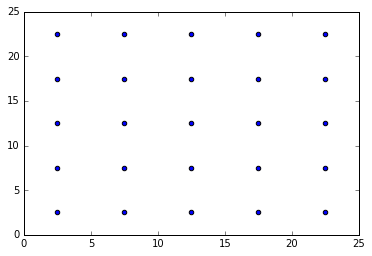

1000 0.0 24.612343227 24.612343227
2000 0.0 24.612343227 24.612343227
3000 0.0 24.612343227 24.612343227
4000 0.0 24.612343227 24.612343227
5000 0.0 24.612343227 24.612343227


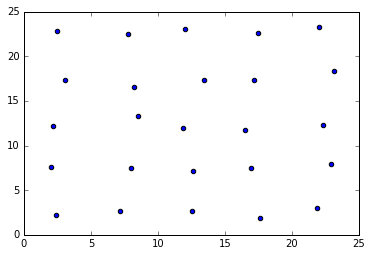

6000 0.0 24.612343227 24.612343227
7000 0.0 24.6129565319 24.6129565319
8000 0.0 24.7218479835 24.7218479835
9000 0.0 25.0092809367 25.0092809367
10000 0.0 25.9456618787 25.9456618787


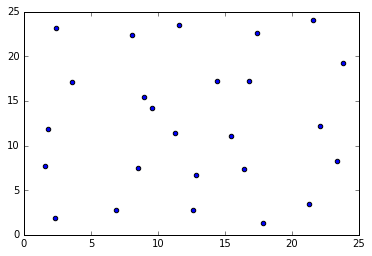

11000 0.0 26.5420632824 26.5420632824
12000 0.0 27.4578525436 27.4578525436
13000 0.0 26.2104527864 26.2104527864
14000 0.0 27.3054768398 27.3054768398
15000 0.0 25.800879558 25.800879558


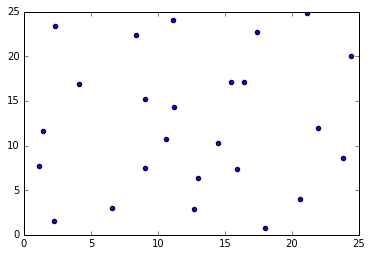

16000 0.0 26.0973533122 26.0973533122
17000 0.0 25.1938401281 25.1938401281
18000 0.0 24.9371163582 24.9371163582
19000 0.0 24.8959217175 24.8959217175
20000 0.0 24.9848294418 24.9848294418


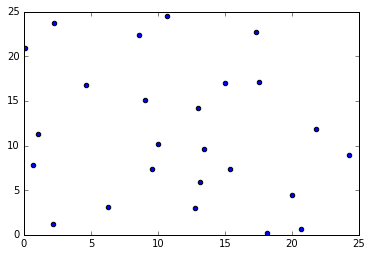

21000 0.0 25.2892998941 25.2892998941
22000 0.0 25.8682313763 25.8682313763
23000 0.0 27.1830726319 27.1830726319
24000 0.0 26.6025892882 26.6025892882
25000 0.0 28.203975333 28.203975333


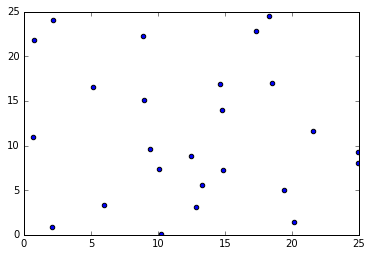

26000 0.0 28.0507478265 28.0507478265
27000 0.0 30.3569601102 30.3569601102
28000 0.0 27.8495433732 27.8495433732
29000 0.0 34.0867640639 34.0867640639
30000 0.0 29.6162188337 29.6162188337


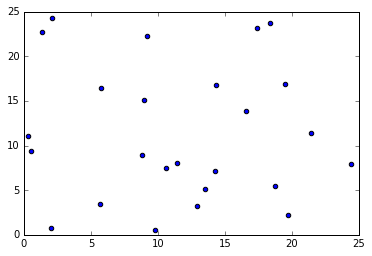

31000 0.0 31.5204423828 31.5204423828
32000 0.0 26.1798181624 26.1798181624
33000 0.0 28.8488031082 28.8488031082
34000 0.0 27.7845854757 27.7845854757
35000 0.0 28.8184089349 28.8184089349


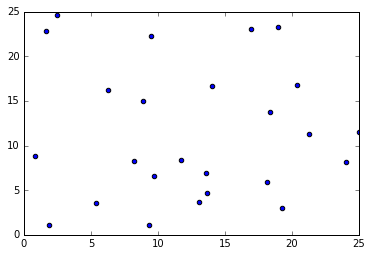

36000 0.0 28.0430813054 28.0430813054
37000 0.0 28.7086363332 28.7086363332
38000 0.0 28.9665523929 28.9665523929
39000 0.0 28.2481004111 28.2481004111
40000 0.0 27.7845181467 27.7845181467


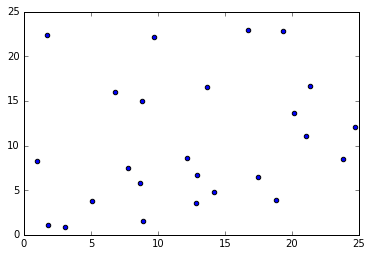

41000 0.0 26.9190858975 26.9190858975
42000 0.0 26.6806848677 26.6806848677
43000 0.0 26.9429338261 26.9429338261
44000 0.0 28.1054264911 28.1054264911
45000 0.0 26.8578305497 26.8578305497


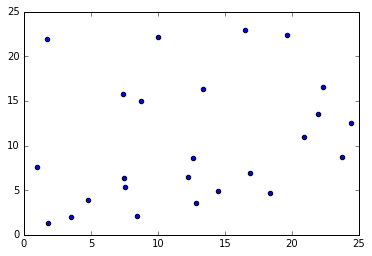

46000 0.0 29.9235851722 29.9235851722
47000 0.0 26.7133308495 26.7133308495
48000 0.0 30.1284978112 30.1284978112
49000 0.0 26.4206539666 26.4206539666
50000 0.0 28.7593596246 28.7593596246


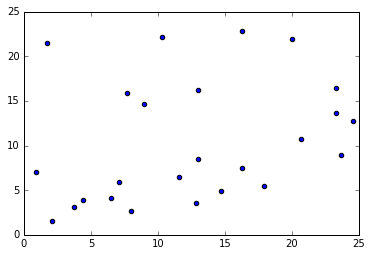

51000 0.0 28.7289374987 28.7289374987
52000 0.0 27.3726805894 27.3726805894
53000 0.0 27.4068382736 27.4068382736
54000 0.0 27.7974016069 27.7974016069
55000 0.0 28.5024655958 28.5024655958


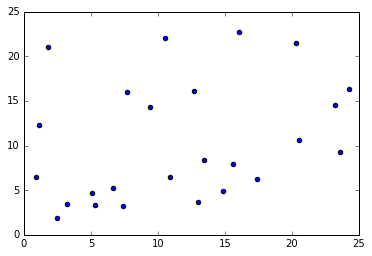

56000 0.0 30.5716785779 30.5716785779
57000 0.0 31.6518152562 31.6518152562
58000 0.0 35.2140534725 35.2140534725
59000 0.0 36.9312666744 36.9312666744
60000 0.0 35.635870226 35.635870226


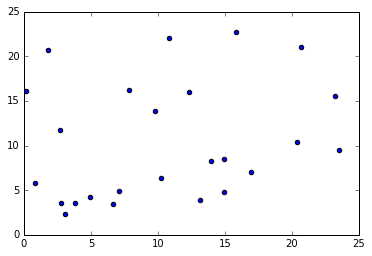

61000 0.0 35.4516689611 35.4516689611
62000 0.0 34.6397146278 34.6397146278
63000 0.0 34.6380783508 34.6380783508
64000 0.0 35.3857993479 35.3857993479
65000 0.0 38.9449740473 38.9449740473


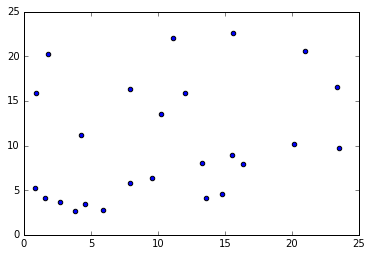

66000 0.0 33.7393788545 33.7393788545
67000 0.0 35.6258581041 35.6258581041
68000 0.0 35.3348629328 35.3348629328
69000 0.0 31.2492585594 31.2492585594
70000 0.0 29.5401661582 29.5401661582


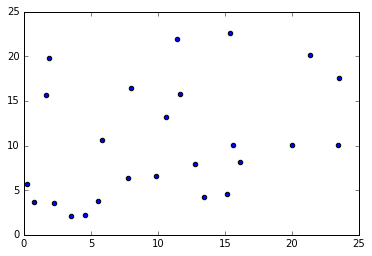

71000 0.0 29.1462200288 29.1462200288
72000 0.0 27.4093865662 27.4093865662
73000 0.0 26.743058903 26.743058903
74000 0.0 26.7969920334 26.7969920334
75000 0.0 27.6744914296 27.6744914296


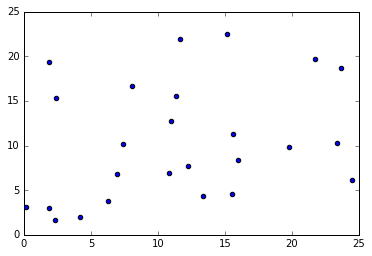

76000 0.0 30.5745410709 30.5745410709
77000 0.0 28.2713568819 28.2713568819
78000 0.0 30.5109230979 30.5109230979
79000 0.0 30.0242822137 30.0242822137
80000 0.0 29.4582695379 29.4582695379


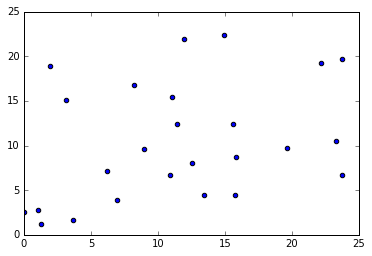

81000 0.0 28.2951357954 28.2951357954
82000 0.0 27.8504220756 27.8504220756
83000 0.0 28.5379390751 28.5379390751
84000 0.0 28.6004399838 28.6004399838
85000 0.0 29.8266194134 29.8266194134


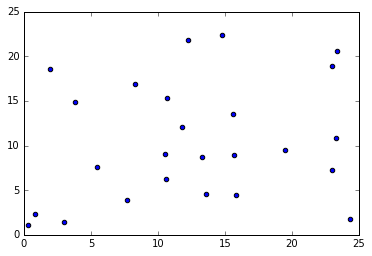

86000 0.0 29.1708743669 29.1708743669
87000 0.0 27.3386827923 27.3386827923
88000 0.0 28.7425627415 28.7425627415
89000 0.0 27.9074854231 27.9074854231
90000 0.0 28.5332436354 28.5332436354


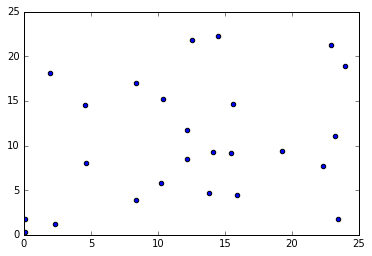

91000 0.0 29.6541746682 29.6541746682
92000 0.0 31.2350095895 31.2350095895
93000 0.0 31.4653980021 31.4653980021
94000 0.0 32.9525349379 32.9525349379
95000 0.0 32.6085795858 32.6085795858


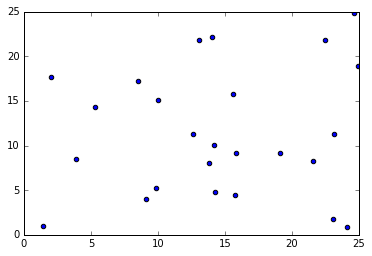

96000 0.0 36.1716993838 36.1716993838
97000 0.0 34.097197151 34.097197151
98000 0.0 35.0493090803 35.0493090803
99000 0.0 33.4492013405 33.4492013405


In [10]:
# Defines location in phase space; initally all values set to 5
Nx=5; Ny=5; N=Nx*Ny
#L=11.22
# crystal when L = 5
L = 25

# not used anywhere yet
T = 1 
k = 1.38e-23

# Simulation parameters
rcut=2.5 # a usual choice for the cutoff radius
dt=1e-4
t_run = 10
Nstep=int(t_run/dt)
viz_jump = 1000
print(Nstep)

vx=np.zeros(N)
vy=np.zeros(N)
rx=np.zeros(N)
ry=np.zeros(N)

rxlog=np.zeros([Nstep,N])
rylog=np.zeros([Nstep,N])
vxlog=np.zeros([Nstep,N])
vylog=np.zeros([Nstep,N])

initialize_positions_and_velocities(rx,ry,vx,vy,Nx,Ny,L)

for i in range(Nstep):
    dV_drx=np.zeros(N)
    dV_dry=np.zeros(N)

    # propagate using forward Euler
#     compute_forces(rx,ry,dV_drx,dV_dry, N, L, rcut)
#     euler(rx,ry,vx,vy,dV_drx,dV_dry,dt)
#     rebox(rx,ry,L)
    
    # propagate using velocity Verlet
    verlet_positions(rx,ry,vx,vy,dV_drx,dV_dry,dt)
    rebox(rx,ry,L)
    compute_forces(rx,ry,dV_drx,dV_dry, N, L, rcut)
    # derive a(t+dt) from the interaction potential using the updated positions    
    verlet_velocity(vx,vy,dV_drx,dV_dry,dt)

    #keep track for printing
    rxlog[i]=rx
    rylog[i]=ry
    vxlog[i]=vx
    vylog[i]=vy

    #get some observables
    Epot=compute_potential_energy(rx,ry,rcut,L)
    Ekin=compute_kinetic_energy(vx,vy)
    if i%viz_jump==0:
        print(i,Epot,Ekin,Epot+Ekin)
#     if i%(5*viz_jump)==0:
#         ax = plt.subplot(111)
#         ax.scatter(rx,ry)
#         ax.set_ylim(0,L)
#         ax.set_xlim(0,L)
#         plt.show()

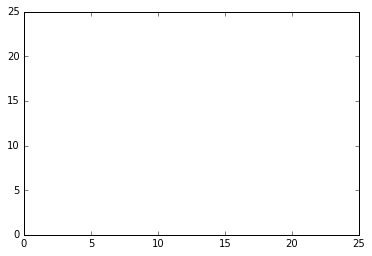

In [15]:
fig = plt.figure()
ax = plt.axes(xlim=(0, L), ylim=(0, L))
# particles, = ax.scatter([],[])
particles, = ax.plot([], [], 'bo', ms=6)

def init():
    particles.set_data([], [])
    return particles,

def pull_positions(i):
    global viz_jump, rxlog, rylog
#    viz_jump = 200
    j = i*viz_jump
    ms = 6
    particles.set_data(rxlog[j],rylog[j])
    particles.set_markersize(ms)
    return particles,

ani = animation.FuncAnimation(fig, pull_positions, frames=np.arange(0,int(Nstep/viz_jump)),init_func=init)     

# Need to have ffmpeg installed to be able to use this
ani.save('LJ_liquid.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

In [14]:
from IPython.display import HTML
HTML(ani.to_html5_video())

## 3: Measurements
Examine the trajectories of your molecules. Find a region of phase space where
the system is solid and another one where it is fluid. Don’t forget to thermalize!
Plot the positions as a function of time to show the difference between the fluid
and the solid.

Where in phase space are we looking?
* Pressure
* Temperature
* Volume/Density

The notes define phase space as the "position and velocity of all particles".

Thus, I think I can edit temperature by including a value for kT in the initializing function.

When should we consider something "thermalized"? --> probably just plot the kinetic energy? maybe the diffusion constant as well? notes warn you to be careful

This 2007 paper looks at LJ crystals: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.76.064121

In [ ]:
# Study the self-diffusion constant D, once the system is already thermalized

## 4: Measurements II
Measure the angle integrated pair correlation function g(r) in both the solid and fluid cases, plot
it as a function of r.